# LDA TOPIC MODELING

This notebook applies LDA modeling to a dataset of news headlines:

https://www.kaggle.com/therohk/million-headlines

run at Dataproc with pySpark:

https://cloud.google.com/dataproc/

and following this repository:

https://github.com/matthiasradtke/topic-modeling-codecentric-blog/blob/master/topicModeling-ccBlog.ipynb

and Apache Spark Documentation:

- http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.clustering.LDA

- https://spark.apache.org/docs/2.1.0/ml-clustering.html#latent-dirichlet-allocation-lda

In [2]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import udf, col, date_format
import pyspark.sql.types as T
from pyspark.ml.feature import CountVectorizer, CountVectorizerModel, IDF, RegexTokenizer, StopWordsRemover
from pyspark.ml.clustering import LDA, LocalLDAModel
from pyspark.ml import Pipeline
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")
import pandas as pd
from wordcloud import WordCloud
import re
import nltk

In [3]:
sc

<SparkContext master=yarn appName=pyspark-shell>

__Loading data__

In [4]:
df = spark.read.csv("gs://ei-db/abcnews-date-text.csv",header=True)

In [5]:
print('Number of news headlines: ', df.count())

Number of news headlines:  1103665


In [6]:
# raw text of the first entry 
df.select('headline_text').take(1)[0][0]

'aba decides against community broadcasting licence'

__First transform dataframe headlines column to RDD to index it to work with__

In [8]:
texts=df.rdd.map(lambda x: x['headline_text'])

In [9]:
#Adding index to data dataframe
headlines=texts.zipWithIndex()

In [10]:
#Creating dataframe
data = sqlContext.createDataFrame(headlines, ["headlines",'index'])

__Normalize and tokenize__

In [12]:
removePunct = udf(
    lambda s: re.sub(r'[^a-zA-Z0-9]|[0-9]', r' ', s).strip().lower(), T.StringType())

# normalize the post content (remove html tags, punctuation and lower case..)
data_norm = data.withColumn("text", removePunct(data.headlines))

In [13]:
# tokenize 
tokenizer = RegexTokenizer(inputCol="text", outputCol="words",
                           gaps=True, pattern=r'\s+', minTokenLength=2)
df_tokens = tokenizer.transform(data_norm)

In [14]:
df_tokens.show()

+--------------------+-----+--------------------+--------------------+
|           headlines|index|                text|               words|
+--------------------+-----+--------------------+--------------------+
|aba decides again...|    0|aba decides again...|[aba, decides, ag...|
|act fire witnesse...|    1|act fire witnesse...|[act, fire, witne...|
|a g calls for inf...|    2|a g calls for inf...|[calls, for, infr...|
|air nz staff in a...|    3|air nz staff in a...|[air, nz, staff, ...|
|air nz strike to ...|    4|air nz strike to ...|[air, nz, strike,...|
|ambitious olsson ...|    5|ambitious olsson ...|[ambitious, olsso...|
|antic delighted w...|    6|antic delighted w...|[antic, delighted...|
|aussie qualifier ...|    7|aussie qualifier ...|[aussie, qualifie...|
|aust addresses un...|    8|aust addresses un...|[aust, addresses,...|
|australia is lock...|    9|australia is lock...|[australia, is, l...|
|australia to cont...|   10|australia to cont...|[australia, to, c...|
|barca

__Removing stopwords__

In [15]:
nltk.download('stopwords')#must be downloaded to run
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
removeStop=udf(lambda word: [x for x in word if x not in stopwords])
df_tokens=df_tokens.withColumn('noStopWords',removeStop(df_tokens['words']))

In [17]:
df_tokens.show()

+--------------------+-----+--------------------+--------------------+--------------------+
|           headlines|index|                text|               words|         noStopWords|
+--------------------+-----+--------------------+--------------------+--------------------+
|aba decides again...|    0|aba decides again...|[aba, decides, ag...|[aba, decides, co...|
|act fire witnesse...|    1|act fire witnesse...|[act, fire, witne...|[act, fire, witne...|
|a g calls for inf...|    2|a g calls for inf...|[calls, for, infr...|[calls, infrastru...|
|air nz staff in a...|    3|air nz staff in a...|[air, nz, staff, ...|[air, nz, staff, ...|
|air nz strike to ...|    4|air nz strike to ...|[air, nz, strike,...|[air, nz, strike,...|
|ambitious olsson ...|    5|ambitious olsson ...|[ambitious, olsso...|[ambitious, olsso...|
|antic delighted w...|    6|antic delighted w...|[antic, delighted...|[antic, delighted...|
|aussie qualifier ...|    7|aussie qualifier ...|[aussie, qualifie...|[aussie, q

In [18]:
df_tokens.printSchema()

root
 |-- headlines: string (nullable = true)
 |-- index: long (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- noStopWords: string (nullable = true)



__Changing noStopWords data type__

It is necessary to change the column data type to run the count vectorizer. It must be T.ArrayType(T.StringType())

In [19]:
label_udf = udf(lambda x: x, T.ArrayType(T.StringType())) 

df_tokens=df_tokens.withColumn('final_words',label_udf(df_tokens.noStopWords))

In [20]:
df_tokens.printSchema()

root
 |-- headlines: string (nullable = true)
 |-- index: long (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- noStopWords: string (nullable = true)
 |-- final_words: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [27]:
df_tokens.show()

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|           headlines|index|                text|               words|         noStopWords|         final_words|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|aba decides again...|    0|aba decides again...|[aba, decides, ag...|[aba, decides, co...|[aba, decides, co...|
|act fire witnesse...|    1|act fire witnesse...|[act, fire, witne...|[act, fire, witne...|[act, fire, witne...|
|a g calls for inf...|    2|a g calls for inf...|[calls, for, infr...|[calls, infrastru...|[calls, infrastru...|
|air nz staff in a...|    3|air nz staff in a...|[air, nz, staff, ...|[air, nz, staff, ...|[air, nz, staff, ...|
|air nz strike to ...|    4|air nz strike to ...|[air, nz, strike,...|[air, nz, strike,...|[air, nz, strike,...|
|ambitious olsson ...|    5|ambitious olsson ...|[ambitious, olsso...|[ambitious, olsso...|[ambi

__TF-IDF Matrix__

Transforming the rdd into a DataFrame which has two columns — one has index and the other the list of words. CountVectorizer takes this data and returns a sparse matrix of term frequencies attached to the original Dataframe. Same thing goes for the IDF

In [28]:
%%time
# TF
#VocabSize of 20000 words and words with frequencies above 10
cv = CountVectorizer(inputCol="final_words", outputCol="raw_features",vocabSize=20000, minDF=10.0)
cvmodel = cv.fit(df_tokens)

result_cv = cvmodel.transform(df_tokens)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 25.3 s


In [30]:
%%time
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 25.2 s


__Train Model__

In [31]:
%%time
#split 80% train set and 20% test set
df_training, df_testing = result_tfidf.randomSplit([0.8, 0.2], 1)
print('Training and testing documents: ', df_training.count(), df_testing.count())

num_topics=30
max_iterations=50
lda = LDA(k=num_topics, maxIter=max_iterations)
ldaModel = lda.fit(result_tfidf )

Training and testing documents:  883474 220191
CPU times: user 180 ms, sys: 104 ms, total: 284 ms
Wall time: 26min 46s


__Perplexity__

In [32]:
lpt, lp = ldaModel.logPerplexity(df_testing), ldaModel.logPerplexity(df_training)
print("Perplexity on testing and training data: " + str(lp) + ',' + str(lpt))

Perplexity on testing and training data: inf,inf


In [38]:
# Print topics and top-weighted terms
topics = ldaModel.describeTopics(maxTermsPerTopic=5)
vocabArray = cvmodel.vocabulary
numTopics=20

ListOfIndexToWords = udf(lambda wl: list([vocabArray[w] for w in wl]))
FormatNumbers = udf(lambda nl: ["{:1.4f}".format(x) for x in nl])

topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).show(truncate=False, n=numTopics)
topics.select(FormatNumbers(topics.termWeights).alias('weights')).show(truncate=False, n=numTopics)

+------------------------------------------------+
|words                                           |
+------------------------------------------------+
|[drug, test, four, rejects, faces]              |
|[work, queensland, budget, green, federal]      |
|[industry, hits, crisis, considers, reports]    |
|[changes, concerns, premier, rates, park]       |
|[bid, media, safety, victims, fears]            |
|[killed, strike, tour, land, family]            |
|[man, charged, murder, missing, woman]          |
|[funding, future, move, abbott, japan]          |
|[rural, national, workers, opposition, business]|
|[north, face, charges, probe, rise]             |
|[security, urges, oil, food, close]             |
|[day, farmers, one, record, inquiry]            |
|[claims, darwin, murray, told, long]            |
|[health, dies, car, perth, assault]             |
|[coast, boost, gold, deal, get]                 |
|[abc, public, arrested, control, energy]        |
|[home, open, return, season, y

__Top Topics__

In [39]:
toptopics = topics.select((topics.topic + 1).alias('topic'),
                          ListOfIndexToWords(topics.termIndices).alias('words'),
                          FormatNumbers(topics.termWeights).alias('weights'))
toptopics.show(truncate=False, n=numTopics)
print('Topics:', numTopics, 'Vocabulary:', len(vocabArray))

+-----+------------------------------------------------+----------------------------------------+
|topic|words                                           |weights                                 |
+-----+------------------------------------------------+----------------------------------------+
|1    |[drug, test, four, rejects, faces]              |[0.0216, 0.0203, 0.0159, 0.0155, 0.0152]|
|2    |[work, queensland, budget, green, federal]      |[0.0228, 0.0198, 0.0182, 0.0166, 0.0165]|
|3    |[industry, hits, crisis, considers, reports]    |[0.0202, 0.0148, 0.0143, 0.0142, 0.0116]|
|4    |[changes, concerns, premier, rates, park]       |[0.0196, 0.0195, 0.0143, 0.0142, 0.0139]|
|5    |[bid, media, safety, victims, fears]            |[0.0169, 0.0148, 0.0145, 0.0143, 0.0141]|
|6    |[killed, strike, tour, land, family]            |[0.0166, 0.0146, 0.0142, 0.0140, 0.0137]|
|7    |[man, charged, murder, missing, woman]          |[0.0398, 0.0278, 0.0264, 0.0226, 0.0190]|
|8    |[funding, fut

__Save Model__

In [ ]:
print(ldaModel.isDistributed())
path = "gs://bucket_name/LDAModel/"

model_number = 'x'
cvModel.save(path + 'CVModel'+ model_number)
ldaModel.save(path + 'LDAModel'+ model_number)
lda.save(path + 'LDA_'+ model_number)

__Details of some topics__

In this case 5 topics. It can be displayed all the topics

In [51]:
df = ldaModel.transform(result_tfidf) #defining the dataframe
numTopics_toShow=5 #
topWords = topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).take(numTopics_toShow)

nTopDoc = 1  # show single top document (1) or also second (2) ..

for i in range(0, numTopics_toShow):
    ntopic = i  # which topic 
    print('Topic ' + str(ntopic) + '\n')  

    df_sliced = df.select("index", "topicDistribution") \
        .rdd.map(lambda r: Row(ID=int(r[0]), weight=float(r[1][ntopic]))).toDF()

    DocIDs = df_sliced.sort(df_sliced.weight.desc()).take(nTopDoc)
    print('Top Document(s):',DocIDs)
    for d_id in DocIDs:
        df_tokens.filter(df_tokens.index == d_id[0]) \
            .select('headlines') \
            .show(truncate=False)

    print('Top terms:')
    print(topWords[ntopic][0], '\n')
    print('===================================================')

Topic 0

Top Document(s): [Row(ID=801645, weight=0.9782088377532229)]
+-----------------------------------------+
|headlines                                |
+-----------------------------------------+
|jim maxwell previews the first ashes test|
+-----------------------------------------+

Top terms:
[drug, test, four, rejects, faces] 

Topic 1

Top Document(s): [Row(ID=654258, weight=0.9736804583104055)]
+--------------------------------------+
|headlines                             |
+--------------------------------------+
|light rail work on track officials say|
+--------------------------------------+

Top terms:
[work, queensland, budget, green, federal] 

Topic 2

Top Document(s): [Row(ID=54316, weight=0.9741522565136251)]
+--------------------------------+
|headlines                       |
+--------------------------------+
|ganguly scoffs at scheduling row|
+--------------------------------+

Top terms:
[industry, hits, crisis, considers, reports] 

Topic 3

Top Document(s): 

__Details of a single topic__

It includes the top topic or second, third, etc., in this case second form example, and the x top terms, in this case 5

In [54]:
# find the top documents according to lda for topic number ntopic
ntopic = 3 # number of topic
nTopDoc = 2 # show top document (1) or second (2) ...

df_sliced = df.select("index","topicDistribution").rdd.map(lambda r: Row(ID = int(r[0]),
                                                                         sliced = float(r[1][ntopic]))).toDF()
topDocID = df_sliced.sort(df_sliced.sliced.desc()).take(nTopDoc)[nTopDoc-1][0]
print(topDocID)
print('Topic ' + str(ntopic) +'\n')

print('Second Document:',DocIDs)
df_tokens.filter(df_tokens.index == topDocID)\
    .select('headlines')\
    .show(truncate = False)

print('Top 5 terms:')
print(topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).take(numTopics)[ntopic][0], '\n')

677619
Topic 3

Second Document: [Row(ID=426766, weight=0.9783422806513288)]
+-----------------------------------------------+
|headlines                                      |
+-----------------------------------------------+
|rba holds fire on rates rba holds fire on rates|
+-----------------------------------------------+

Top 5 terms:
[changes, concerns, premier, rates, park] 



__Plot the top documents result__

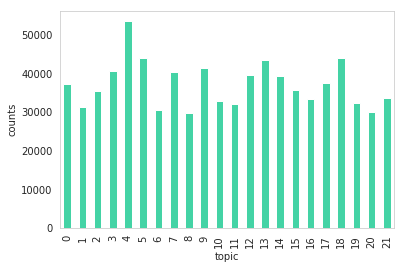

In [57]:
countTopDocs = df.select('topicDistribution')\
                .rdd.map(lambda r: Row( nTopTopic = int(np.argmax(r)))).toDF() \
                .groupBy("nTopTopic").count().sort("nTopTopic")

pdf = countTopDocs.toPandas()
pdfLess = pdf.drop(pdf.index[[1,3,7,8,10,11,14,15]]).reset_index()

pdfLess.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

__Predicting a single document__

In [60]:
indexPost = 0
idd = 99999 #For example

testTopicDistributions = ldaModel.transform(result_tfidf)

alist = testTopicDistributions.filter(testTopicDistributions.
                                      index == idd).select("topicDistribution").collect()[0][0]
print([ (index+1,float("{0:.3f}".format(item)) ) for (index,item) in enumerate( alist ) ])

df_tokens.filter(df_tokens.index == idd).select("headlines").collect()

[(1, 0.001), (2, 0.001), (3, 0.001), (4, 0.219), (5, 0.095), (6, 0.001), (7, 0.001), (8, 0.001), (9, 0.001), (10, 0.001), (11, 0.001), (12, 0.001), (13, 0.001), (14, 0.448), (15, 0.001), (16, 0.001), (17, 0.001), (18, 0.001), (19, 0.001), (20, 0.001), (21, 0.001), (22, 0.001), (23, 0.001), (24, 0.001), (25, 0.001), (26, 0.001), (27, 0.215), (28, 0.001), (29, 0.001), (30, 0.001)]


[Row(headlines='call for drip feed baby bonus')]